#  Customer Churn Analysis – EDA & Feature Engineering
## 📌 Objective

The goal of this analysis is to identify key factors that influence customer churn in a telecom company and prepare the data for predictive modeling. We aim to:

- Understand churn behavior through visual exploration
- Engineer meaningful features to enhance model accuracy
- Provide actionable business insights that could reduce churn

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set styles
sns.set(style="whitegrid")
%matplotlib inline

# Load dataset
df = pd.read_csv("/kaggle/input/telecom-cleaned/cleaned.csv")  

# Preview the data
df.head()


## 🔍 Churn Distribution (Target Variable)

Let's start by exploring the target variable: **Churn**. This will help us understand the class balance.

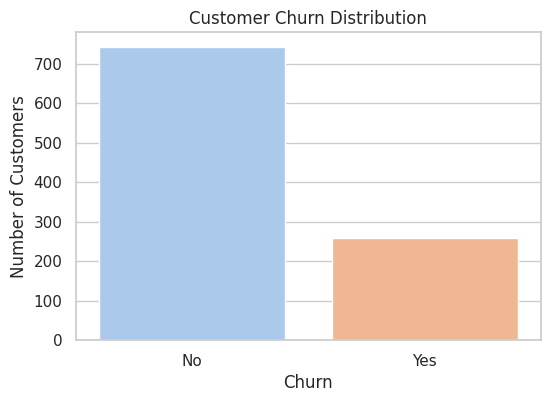

Churn Rate:
 Churn
No     74.2
Yes    25.8
Name: count, dtype: float64


In [6]:
# Churn counts
churn_counts = df['Churn'].value_counts()

# Plot churn distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn', palette='pastel')
plt.title("Customer Churn Distribution")
plt.ylabel("Number of Customers")
plt.xlabel("Churn")
plt.show()

# Optional: Percentage
churn_pct = churn_counts / churn_counts.sum() * 100
print("Churn Rate:\n", churn_pct)


### 💡 Insight:
- About **26% of customers** have churned. This shows **moderate class imbalance**, which is important to consider when modeling.

## 🔄 Churn vs. Contract Type

Here we explore how **contract type** relates to churn. Customers can have month-to-month, one-year, or two-year contracts.

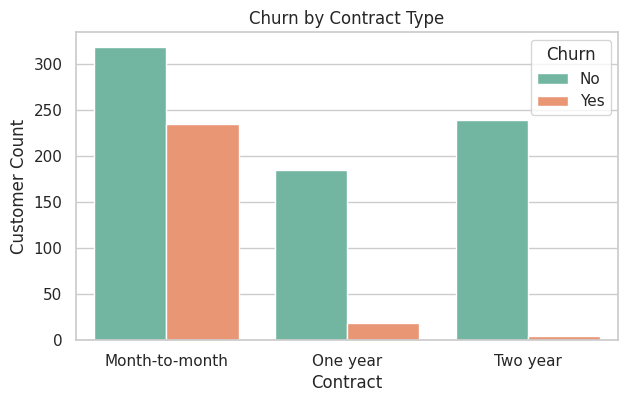

In [7]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='Contract', hue='Churn', palette='Set2')
plt.title("Churn by Contract Type")
plt.ylabel("Customer Count")
plt.show()


### 💡 Insight:
- Customers on **month-to-month contracts churn significantly more** than those on yearly contracts.
- Long-term contracts seem to encourage loyalty and reduce churn.

## ⏳ Churn vs. Tenure

This helps us understand how the length of time a customer has stayed affects churn behavior.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

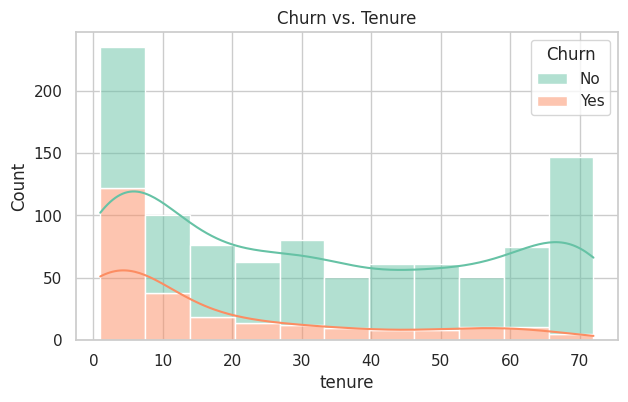

In [8]:
plt.figure(figsize=(7,4))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, multiple='stack', palette='Set2')
plt.title("Churn vs. Tenure")
plt.show()


### 💡 Insight:
- **Newer customers (tenure < 12 months)** have the highest churn rates.
- As tenure increases, churn probability **drops significantly**.
- This suggests that churn prevention efforts should **target new customers early**.

## 💸 Monthly Charges vs. Churn

Let’s see if higher monthly costs contribute to churn.


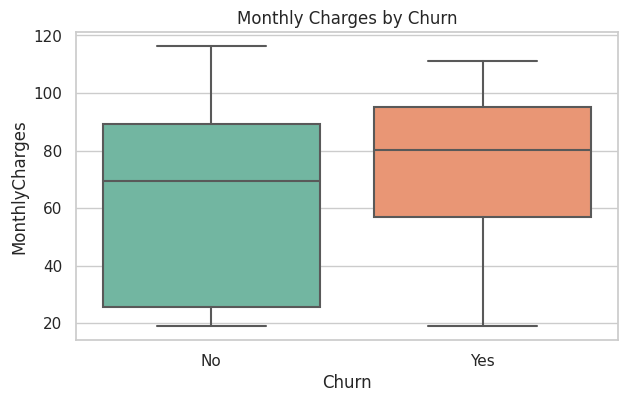

In [9]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='Set2')
plt.title("Monthly Charges by Churn")
plt.show()


### 💡 Insight:
- Churn is more common among customers with **higher monthly charges**.
- There may be a **perceived value or satisfaction gap** in more expensive service plans.


## 🔗 Correlation Analysis

We use a heatmap to understand relationships between numeric variables, including churn.


## 🔗 Correlation Analysis

We use a heatmap to understand relationships between numeric variables, including churn.


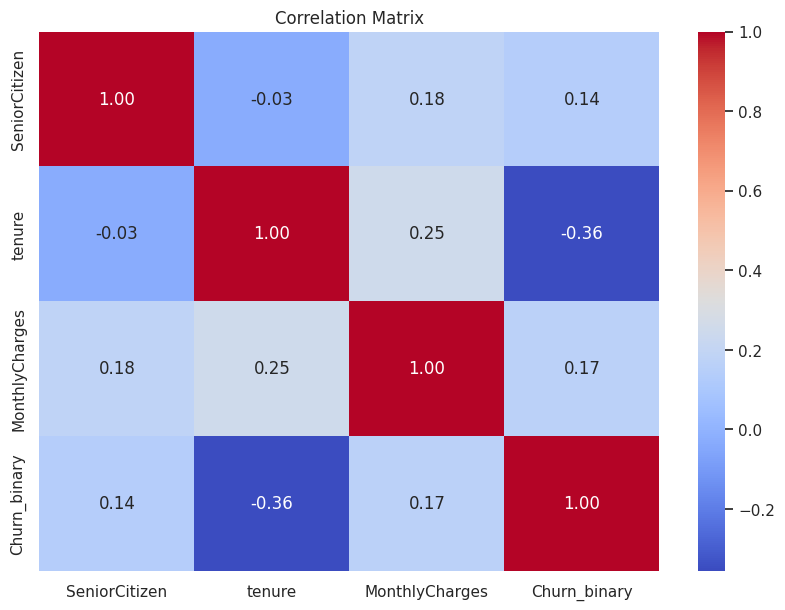

In [10]:
# Convert Churn to binary for correlation
df['Churn_binary'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Select numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation matrix
plt.figure(figsize=(10,7))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


### 💡 Insight:
- `tenure` and `Churn` show a **strong negative correlation** — as tenure increases, churn decreases.
- `MonthlyCharges` is **positively correlated** with churn, supporting our earlier insight.


# Now we move to Feature enginnering

In [11]:
def label_tenure(t):
    if t <= 12:
        return '0–1 year'
    elif t <= 24:
        return '1–2 years'
    elif t <= 48:
        return '2–4 years'
    else:
        return '4+ years'

df['tenure_group'] = df['tenure'].apply(label_tenure)


In [13]:
df['estimated_lifetime_value'] = df['tenure'] * df['MonthlyCharges']

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

In [15]:
df_encoded = df.copy()

# Binary columns that can be label encoded
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

le = LabelEncoder()
for col in binary_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])


In [16]:
# Drop original churn label (text) if still present
df_encoded.drop(['Churn'], axis=1, inplace=True)

# Columns to one-hot encode
multi_cat_cols = ['Contract', 'InternetService', 'PaymentMethod', 'tenure_group']

df_encoded = pd.get_dummies(df_encoded, columns=multi_cat_cols, drop_first=True)


In [22]:
# Example: copy original dataframe and prepare to one-hot encode
df_encoded = df.copy()

# Encode target
df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

# Drop text target column if needed
df_encoded.drop(columns=['Churn_binary'], errors='ignore', inplace=True)

# Identify categorical columns
cat_cols = df_encoded.select_dtypes(include='object').columns.tolist()

# One-hot encode remaining categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)


In [24]:
# Define features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit model
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [29]:
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)



In [30]:
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       224
           1       0.70      0.55      0.62        76

    accuracy                           0.83       300
   macro avg       0.78      0.74      0.75       300
weighted avg       0.82      0.83      0.82       300


Random Forest Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       224
           1       0.69      0.57      0.62        76

    accuracy                           0.83       300
   macro avg       0.78      0.74      0.76       300
weighted avg       0.82      0.83      0.82       300



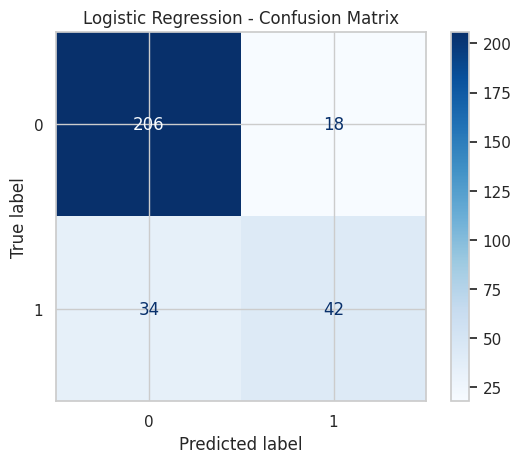

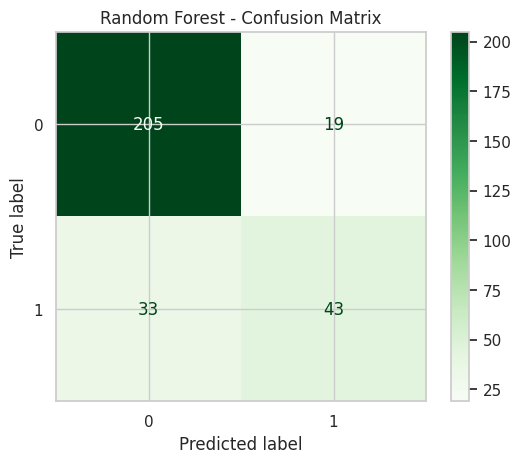

In [31]:
ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap="Greens")
plt.title("Random Forest - Confusion Matrix")
plt.show()


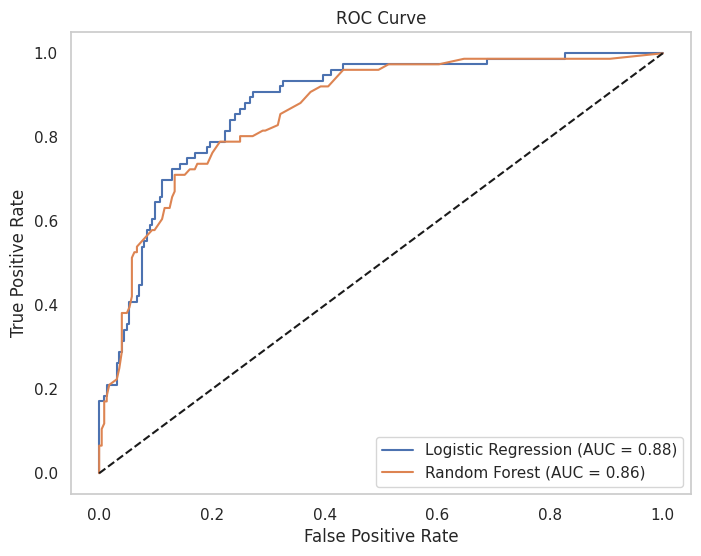

In [32]:
y_proba_lr = lr_model.predict_proba(X_test)[:,1]
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_lr)))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba_rf)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


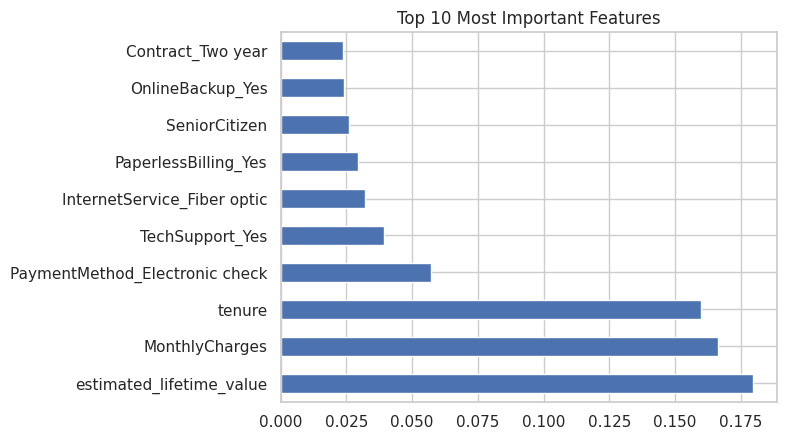

In [33]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Most Important Features")
plt.show()


## 🧪 Feature Engineering Summary

We created the following features to help the model:
- `tenure_group`: groups customers by how long they’ve been active
- `estimated_lifetime_value`: tenure × monthly charges (proxy for lifetime revenue)

These features will help our model capture patterns more clearly.


# 📌 Summary of EDA Findings & Business Insights

## 🔍 Key Observations:
- **Churn rate** is about **26%**, indicating a real business risk.
- **Month-to-month contracts** have the highest churn — lock-in periods may help retain users.
- **Short-tenure customers (<12 months)** are most at risk — loyalty campaigns should target them early.
- **High monthly charges** correlate with higher churn — pricing strategies could be reviewed.

## 💼 Business Recommendations:
1. Offer loyalty bonuses or discounts to customers in their first 6–12 months.
2. Encourage customers to move from month-to-month to annual contracts.
3. Review pricing plans with high monthly charges and ensure they match value delivery.
4. Identify high-risk customers early and create retention-focused touchpoints.

Next step: We'll train machine learning models to predict churn and test how accurately we can flag high-risk customers.
